## Titanic datasett
### Grunnleggende maskinlæringsoppgave
Vår tilnærming: Vise effekten av å kunne ta med mange parametre. (Positiv effekt, forhåpentligvis)

In [27]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn import tree, naive_bayes
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'svg'

In [28]:
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
X = X.drop(['boat', 'body', 'home.dest'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

In [29]:
X

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S
3,1.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S
...,...,...,...,...,...,...,...,...,...,...
1304,3.0,"Zabour, Miss. Hileni",female,14.5000,1.0,0.0,2665,14.4542,None,C
1305,3.0,"Zabour, Miss. Thamine",female,NaN,1.0,0.0,2665,14.4542,None,C
1306,3.0,"Zakarian, Mr. Mapriededer",male,26.5000,0.0,0.0,2656,7.2250,None,C
1307,3.0,"Zakarian, Mr. Ortin",male,27.0000,0.0,0.0,2670,7.2250,None,C


In [30]:
# Hvor mange tomme felter er det i hver kolonne?
X_train.isnull().sum()

pclass        0
name          0
sex           0
age         209
sibsp         0
parch         0
ticket        0
fare          1
cabin       811
embarked      2
dtype: int64

In [31]:
# Vi må gjøre no med nullene i age, cabin og embarked.
# Vi sletter cabin - kolonna.
X_train = X_train.drop(['cabin'], axis=1)
X_test = X_test.drop(['cabin'], axis=1)

In [32]:
X_train.isnull().sum()

pclass        0
name          0
sex           0
age         209
sibsp         0
parch         0
ticket        0
fare          1
embarked      2
dtype: int64

In [33]:
# FØr vi gjør noe med manglende alder, finner vi tittelen på folk.
# Den er det noen som bruker til segmentering
# name har navnet på denne formen: Silvey, Mr. William Baird
# Tittelen er det som kommer foran eneste/ første punktum, og etter et mellomrom.

X_train['title'] = X_train['name'].str.extract(' ([A-Za-z]+)\.', expand=False)
X_test['title'] = X_test['name'].str.extract(' ([A-Za-z]+)\.', expand=False)

In [34]:
X_train

,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked,title
631,3.0,"Andersson, Mr. Johan Samuel",male,26.0,0.0,0.0,347075,7.7750,S,Mr
557,2.0,"Shelley, Mrs. William (Imanita Parrish Hall)",female,25.0,0.0,1.0,230433,26.0000,S,Mrs
224,1.0,"Partner, Mr. Austen",male,45.5,0.0,0.0,113043,28.5000,S,Mr
298,1.0,"Tucker, Mr. Gilbert Milligan Jr",male,31.0,0.0,0.0,2543,28.5375,C,Mr
281,1.0,"Stengel, Mrs. Charles Emil Henry (Annie May Mo...",female,43.0,1.0,0.0,11778,55.4417,C,Mrs
...,...,...,...,...,...,...,...,...,...,...
604,3.0,"Abelseth, Miss. Karen Marie",female,16.0,0.0,0.0,348125,7.6500,S,Miss
74,1.0,"Clifford, Mr. George Quincy",male,NaN,0.0,0.0,110465,52.0000,S,Mr
565,2.0,"Sobey, Mr. Samuel James Hayden",male,25.0,0.0,0.0,C.A. 29178,13.0000,S,Mr
942,3.0,"Lahoud, Mr. Sarkis",male,NaN,0.0,0.0,2624,7.2250,C,Mr


In [35]:
# Nå kan vi bruke tittelen og si at de som mangler angivelse av alder, de kan få median av alder for den gruppen.
X_train["age"] = X_train["age"].fillna(X_train.groupby("title")["age"].transform("median"))
X_test["age"] = X_test["age"].fillna(X_test.groupby("title")["age"].transform("median"))
# Vi gjør det samme med fare og embarked
X_train["fare"] = X_train["fare"].fillna(X_train.groupby("title")["fare"].transform("median"))
X_test["fare"] = X_test["fare"].fillna(X_test.groupby("title")["fare"].transform("median"))

In [36]:
X_train.isnull().sum()

pclass      0
name        0
sex         0
age         0
sibsp       0
parch       0
ticket      0
fare        0
embarked    2
title       0
dtype: int64

In [37]:
# embarked inneholder bokstaver, så der kan vi ikke brukge median. Vi tar det vanligste ombordstigningsstedet for de to som mangler:
X_train["embarked"].value_counts()

S    736
C    213
Q     96
Name: embarked, dtype: int64

In [38]:

X_train["embarked"] = X_train["embarked"].fillna("S")
X_test["embarked"] = X_test["embarked"].fillna("S")
X_test["embarked"].value_counts()

S    178
C     57
Q     27
Name: embarked, dtype: int64

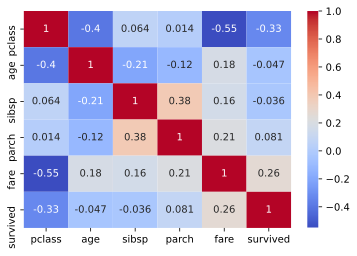

In [39]:
# Korrelasjoner
X_comb = pd.concat([X_train, y_train.astype(float)], axis=1)
g = sns.heatmap(X_comb[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'survived']].corr(),
                annot=True, 
                cmap = "coolwarm")

### Korrelasjoner
I tabellen over, ser vi at Passasjerklasse (første andre, tredje) korrelerer med overlevelse. Negativt tall fordi høyt tall på passasjerklasse gir lavere sannsynliget for overlevelse.
Det samme kommer fram ved at høyere billettpris gir høyere sannsynlighet for overlevelse.
sibsp forteller  hvor mange søsken eller ektefelle som er med på turen
parch gir hvor mange foreldre eller barn som er med på turen.
kjønn er ikke med, siden den verien fortsatt er bokstav-verdi, og derfor får vi ikke til å lage korrelasjonskoeffisient.
Men vi kan se på noen visualiseringer:


1.0    167
3.0    143
2.0     90
Name: pclass, dtype: int64


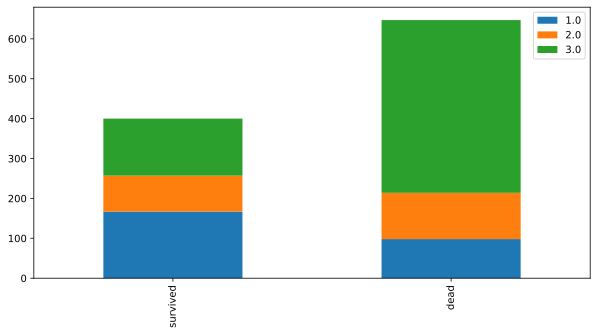

In [40]:
# https://www.kaggle.com/minsukheo/titanic-solution-with-sklearn-classifiers
def bar_chart(feature):
    survived = X_comb[X_comb['survived']==1][feature].value_counts()
    dead = X_comb[X_comb['survived']==0][feature].value_counts()
    print(survived)
    df = pd.DataFrame([survived,dead])
    df.index = ['survived','dead']
    df.plot(kind='bar',stacked=True, figsize=(10,5))
bar_chart ("pclass")
## Vi ser at flertallet av de i første klasse overlevde, mens flertallet av de på tredje klasse døde.

female    269
male      131
Name: sex, dtype: int64


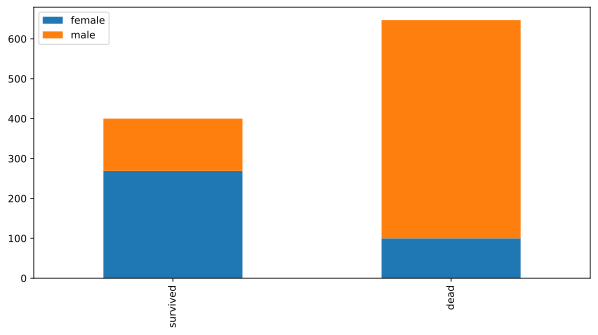

In [41]:
# For kjønn får vi dette:
bar_chart ("sex")
#Her ser vi en sterk ubalanse: Flertallet av menna døde, flertallet av kvinnene overlevde

In [42]:
# Vi kan for øvingensskyld stoppe der, og se hva vi får ut av å bruke denne informasjonen.
# Vi kan gruppere folk i både klasse og kjønn, og se andelen som overlevde
print("klasse", "kjønn","\t","overl", "\t","ant", "\t", "andel overlevende")
for pc, pcg in X_comb.groupby("pclass"):
    for sx, sxg in pcg.groupby("sex"):
        survived = len(sxg[sxg['survived']==1])
        print(pc, sx,"\t",survived, "\t",len(sxg), "\t", round(survived/ len(sxg), 3) )


klasse kjønn 	 overl 	 ant 	 andel overlevende
1.0 female 	 115 	 119 	 0.966
1.0 male 	 52 	 146 	 0.356
2.0 female 	 68 	 77 	 0.883
2.0 male 	 22 	 129 	 0.171
3.0 female 	 86 	 173 	 0.497
3.0 male 	 57 	 403 	 0.141


Vi ser at for alle kvinner er sannsynligheten for å overleve (så vidt for 3. klasse) over 50%. 
For alle menn er sansynligheten for å overleve under 50%. 
Vi kan derfor si at vi predikerer for alle menn at de vil dø, mens for alle kvinner predikerer vi at de vil overleve.


In [43]:
# Prediksjon på bakgrunn av kjønn:
pd_est = X_comb[["sex", "survived"]].copy()
pd_est["estimated"] = 0
pd_est.loc[pd_est["sex"]=="female","estimated"] = 1
pd_est["correct"] = 0
pd_est.loc[pd_est["survived"] ==pd_est["estimated"], "correct"] = 1

for sx, sxg in pd_est.groupby("sex"):
    print(sx, "andel korrekt estimerte\t", round(sxg["correct"].sum() / len(sxg), 3) )
print("samlet", "andel korrekt estimerte\t", round(pd_est["correct"].sum() / len(pd_est),3) )

female andel korrekt estimerte	 0.729
male andel korrekt estimerte	 0.807
samlet andel korrekt estimerte	 0.779


In [44]:
# Så bare ved å estimere hvem som overlevde, ut fra kjønn, får vi 77,5% riktig.
# Modellene vi lager, må slå det for å ha noen verdi. 
# Nå skal vi bruke mer avanserte verktøy som kan ta inn mange parametre (mye informasjon på hver person).
# Når vi trener statistiske modeller må vi ha tallverdier i alle kolonner
sex_conv = {"male":0, "female":1}

modeller = [naive_bayes.CategoricalNB(), tree.DecisionTreeClassifier()]
df_x = X_train[["sex", "pclass"]].copy()
df_x["sex"] = df_x["sex"].map(sex_conv)

dtc = tree.DecisionTreeClassifier()
nbc = naive_bayes.MultinomialNB()


print("Decision tree", round(cross_val_score(dtc, df_x, y_train, cv=5, scoring="accuracy").mean(), 3))
print("Naive Bayes", round(cross_val_score(nbc, df_x, y_train, cv=5, scoring="accuracy").mean(), 3))
# dtc.fit(df_x, y_train)
# tree.plot_tree(dtc)

Decision tree 0.774
Naive Bayes 0.779


In [45]:
#Vi ser at Decision tree og Naive Bayes er like gode som å bare estimere utfra kjønn
# Men nå bygger vi opp dataene med flere kolonner
#  'age', 'sibsp', 'parch', 'fare'
# Men da må vi 'normalisere' dataene så alle ligger mellom 0 og 1, ellers vil de 
# dataene med høye verdier, som alder og pris, overskygge de andre.
df_x = X_train[["sex", "pclass","age" ]].copy()
df_x["sex"] = df_x["sex"].map(sex_conv)

modeller = {"Decision tree":tree.DecisionTreeClassifier(), "Naive Bayes": naive_bayes.MultinomialNB()}
for navn, modell in modeller.items():
    steps = [('scaler', StandardScaler()), ('model', modell) ]
    pipeline = Pipeline(steps)
    print(navn, round(cross_val_score(modell, df_x, y_train, cv=5, scoring="accuracy").mean(), 3))






# print("Naive Bayes", round(cross_val_score(nbc, df_x, y_train, cv=5, scoring="accuracy").mean(), 3))


Decision tree 0.812
Naive Bayes 0.779


In [46]:
# Ikke mye å hente på å legge til alder.
# Vi tar med resten også. 
df_x = X_train[["sex", "pclass","age" , 'fare']].copy()
df_x['family_size'] = X_train['parch'] + X_train['sibsp'] # Slå sammen vertikale og horisontale fam medl
df_x["sex"] = df_x["sex"].map(sex_conv)
df_x['is_alone'] = 1
df_x['is_alone'].loc[df_x['family_size'] > 1] = 0

modeller = {"Decision tree":tree.DecisionTreeClassifier(), "Naive Bayes": naive_bayes.MultinomialNB()}
for navn, modell in modeller.items():
    steps = [('scaler', StandardScaler()), ('model', modell) ]
    pipeline = Pipeline(steps)
    print(navn, round(cross_val_score(modell, df_x, y_train, cv=5, scoring="accuracy").mean(), 3))



Decision tree 0.763
Naive Bayes 0.695


In [47]:
# Ikke noe bedre. Klart dårligere for Naive Bayes. Vi henter inn litt tyngre skyts: random forest og SVM
modeller = {"Decision tree":tree.DecisionTreeClassifier(), "Naive Bayes": naive_bayes.MultinomialNB(), 
            "Support Vector Machine":SVC (),"Random forest": RandomForestClassifier()}
for navn, modell in modeller.items():
    steps = [('scaler', StandardScaler()), ('model', modell) ]
    pipeline = Pipeline(steps)
    print(navn, round(cross_val_score(modell, df_x, y_train, cv=5, scoring="accuracy").mean(), 3))


Decision tree 0.759
Naive Bayes 0.695
Support Vector Machine 0.684
Random forest 0.787


Nå har vi en liten gevinst.  
Random Forest gir oss 79,8 % riktig estimat av om folk døde, basert på klasse, kjønn, bilettpris, alder, og antall familiemedlemmer som var med.
Da vi bare esteimerte basert på kjønn, fikk vi 77,5% riktig.  

For å komme videre, skal vi bruke ombordstigingshavn og tittel. Vi bruker "One-hot" encoding der vi lager ei kolonne for hver kategori, og så setter vi 1 på de som denne kategorien gjelder for.
 

In [48]:
ports = list(X_train["embarked"].unique())
ports

['S', 'C', 'Q']

In [49]:
for port in X_train["embarked"].unique():
    df_x[port] = 0
    df_x.loc[X_train["embarked"]==port, port] = 1

In [50]:
print(X_train["title"].value_counts()[:7])
print(X_train["title"].unique())
titles = ['Mrs', 'Mr', 'Miss' ,'Master']
for title in titles:
    df_x[title] = 0
    df_x.loc[X_train["title"]==title, title] = 1

Mr        606
Miss      204
Mrs       158
Master     49
Dr          7
Rev         7
Col         4
Name: title, dtype: int64
['Mr' 'Mrs' 'Miss' 'Master' 'Rev' 'Dr' 'Col' 'Don' 'Mme' 'Mlle' 'Major'
 'Jonkheer' 'Sir' 'Countess' 'Dona' 'Capt' 'Ms']


In [51]:
modeller = {"Decision tree":tree.DecisionTreeClassifier(), "Naive Bayes": naive_bayes.MultinomialNB(), 
            "Support Vector Machine":SVC(),"Random forest": RandomForestClassifier()}
for navn, modell in modeller.items():
    steps = [('scaler', StandardScaler()), ('model', modell) ]
    pipeline = Pipeline(steps)
    print(navn, round(cross_val_score(modell, df_x, y_train, cv=5, scoring="accuracy").mean(), 3))

Decision tree 0.784
Naive Bayes 0.704
Support Vector Machine 0.688
Random forest 0.787


### Vi er fortsatt ikke over 80%
Nå skal vi utforske hyperparametrene på SVM of Random Forest. De to har mest å hente på det, tenker jeg


In [53]:
params = {'model__max_depth': [4,6,9,15, None], 
         'model__n_estimators':[ 150, 200, 250, 300], 
          'model__max_features': [1,3,6,None],
          'model__criterion' : ['gini', 'entropy'],
          'model__bootstrap':[True, False] }
# rnd_search = RandomizedSearchCV(RandomForestClassifier(), params, n_iter =20, cv=5)
modell = RandomForestClassifier()
steps = [('scaler', StandardScaler()), ('model', modell) ]
pipeline = Pipeline(steps)
def kjor_random_forest():
    rsearch = RandomizedSearchCV(pipeline, params, n_iter =50, cv=5, verbose=1)
    rsearch.fit( df_x, y_train)  # Tar lang tid
    print("Random Forest beste score", round(rsearch.best_score_, 4))
    pd.DataFrame(rsearch.cv_results_).to_csv("random_forest_search")
    rsearch.best_params_ # Feiler når vi ikke har trent modellen
''' {'model__n_estimators': 200,
 'model__max_features': 3,
 'model__max_depth': 6,
 'model__criterion': 'gini',
 'model__bootstrap': True}   '''
# kjor_random_forest # Tar lang tid

In [19]:
# Det samme for SVC
import scipy
params = {'model__C': scipy.stats.expon(scale=100)
    , 'model__gamma': scipy.stats.expon(scale=.1)
    , 'model__kernel': ['linear','rbf']
    , 'model__class_weight':['balanced', None]}

modell = SVC()
steps = [('scaler', StandardScaler()), ('model', modell) ]
pipeline = Pipeline(steps)
rsearch = RandomizedSearchCV(pipeline, params, n_iter =40, cv=5, verbose=1)
rsearch.fit( df_x, y_train)  # Tar lang tid
print("SVC beste score", round(rsearch.best_score_, 4))

NameError: name 'df_x' is not defined

## Men hva med  litt mer skikkelig kunstig intelligens? 
Jeg er litt usikker på når vi skla bruke begrepet "Kunstig intelligense", men jeg vet hvordan bruke nevrale nettverk, og dype nevrale nettverk.
Vi kjører tester også med å trene opp en modell baserrt på dype nevrale nett:
